# **Space X Falcon 9 First Stage Landing Prediction**

## Hands on Lab: Complete the Machine Learning Prediction lab**

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)

Several examples of an unsuccessful landing are shown here:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)

Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.

## Objectives

Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

## Import Libraries and Define Auxiliary Functions

In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])


In [3]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix

In [4]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe

Load the data

In [5]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [6]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [7]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [8]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1

Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).

In [9]:
Y = data['Class'].to_numpy()

In [10]:
type(Y)

numpy.ndarray

## TASK  2

Standardize the data in X then reassign it to the variable X using the transform provided below.

In [11]:
transform = preprocessing.StandardScaler()
X_std = transform.fit_transform(X)

We split the data into training and testing data using the function train_test_split. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function GridSearchCV.

## TASK  3

Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to 0.2 and random_state to 2. The training data and test data should be assigned to the following labels.

<code>X_train, X_test, Y_train, Y_test</code>

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size =0.2, random_state = 2)

we can see we only have 18 test samples.

In [13]:
Y_test.shape

(18,)

## TASK  4

Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [14]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv = 10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the GridSearchCV object for logistic regression. We display the best parameters using the data attribute best_params_ and the accuracy on the validation data using the data attribute best_score_.

In [17]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5

Calculate the accuracy on the test data using the method score:

In [18]:
test_accuracy = logreg_cv.score(X_test, Y_test)
print(f"Accuracy on test data: {test_accuracy:.4f}")

Accuracy on test data: 0.8333


Lets look at the confusion matrix:

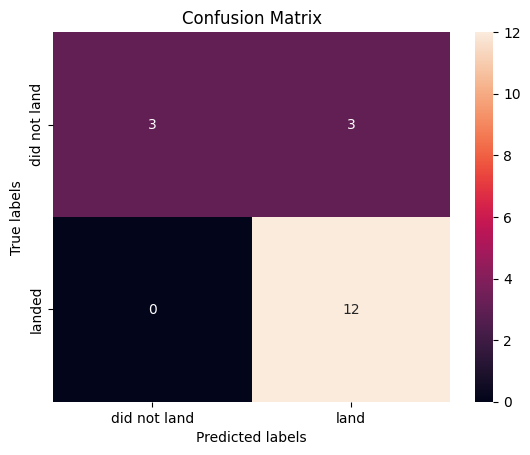

In [19]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)

## TASK  6

Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [20]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [21]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [22]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7

Calculate the accuracy on the test data using the method <code>score</code>:

In [23]:
svm_test_accuracy = svm_cv.score(X_test, Y_test)
print(f"SVM Accuracy on test data: {svm_test_accuracy:.4f}")

SVM Accuracy on test data: 0.8333


We can plot the confusion matrix

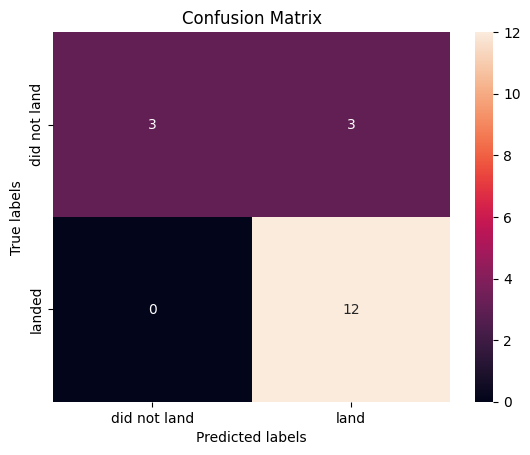

In [24]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8

Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [25]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [26]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_p

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [27]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8910714285714286


## TASK  9

Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:

In [28]:
tree_test_accuracy = tree_cv.score(X_test, Y_test)
print(f"Tree Accuracy on test data: {tree_test_accuracy:.4f}")

Tree Accuracy on test data: 0.7778


We can plot the confusion matrix

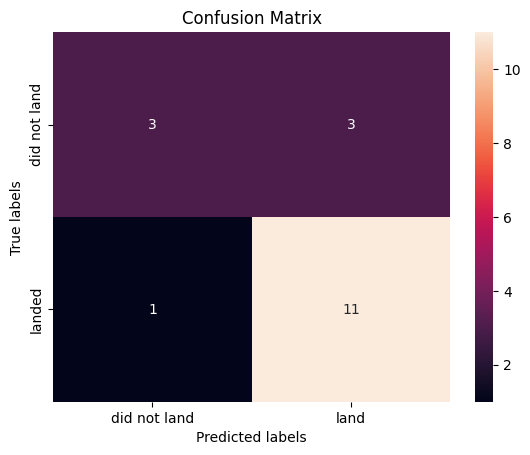

In [29]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.

In [30]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [31]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [32]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11

Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:

In [33]:
knn_test_accuracy = knn_cv.score(X_test, Y_test)
print(f"KNN Accuracy on test data: {knn_test_accuracy:.4f}")

KNN Accuracy on test data: 0.8333


We can plot the confusion matrix

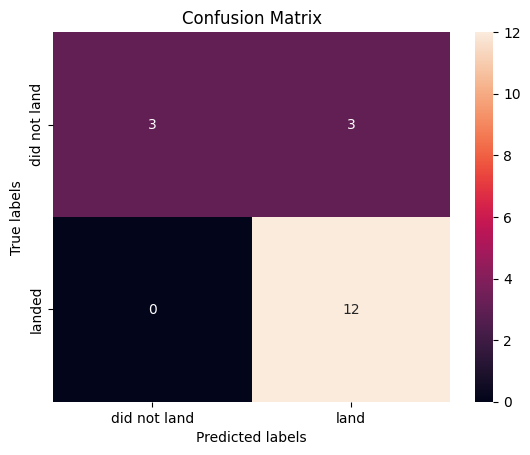

In [34]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:

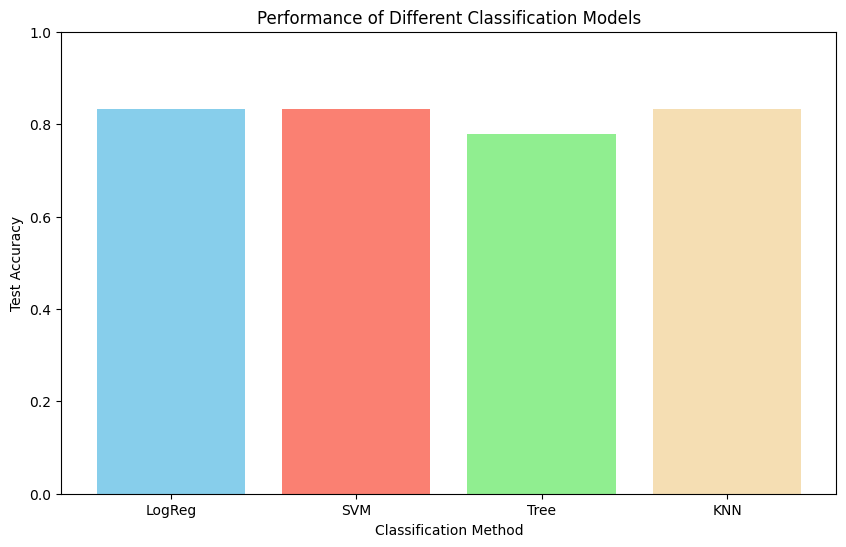

In [35]:
import matplotlib.pyplot as plt

# Store the scores in a dictionary
methods = ['LogReg', 'SVM', 'Tree', 'KNN']
scores = [
    logreg_cv.score(X_test, Y_test), 
    svm_cv.score(X_test, Y_test), 
    tree_cv.score(X_test, Y_test), 
    knn_cv.score(X_test, Y_test)
]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(methods, scores, color=['skyblue', 'salmon', 'lightgreen', 'wheat'])
plt.xlabel('Classification Method')
plt.ylabel('Test Accuracy')
plt.title('Performance of Different Classification Models')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.show()